In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib, copy
from glob import glob
import pickle
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.electromagnetic import FreeVectorPotential, CavityVectorPotential

from matter.atoms import AtomsInBox
from calculator.calculator import Calculator

from utilities.etc import categorizing_result

import animation as an
import analyze_tools.utils as atu
from analyze_tools.monte_carlo import get_colliding_time

from simulation.single import single_collision_simulation
import utilities.reduced_parameter as red
from utilities.etc import moving_average


Epsilon (erg) 1.6538969109051514e-14
Reduced epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.3825301204819278 ; 1.9116465863453815
CGS epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.6538969109051514e-14 ; 2.286562295498387e-14 ; 3.161666383899004e-14
######################
Length multiple - Sigma (cm) 3.41e-08
Reduced sigma (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.095307917888563 ; 1.190615835777126
######################
Mass multiples (g) 6.633521465546083e-23
Reduced Mass (Ar, Xe): 1.0 ; 3.286597576849905
######################
Dipole unit multiple (statC . cm) 8.09814943451058e-19
Reduced dipole parameter:
mu0 =  0.08920009870622121
a =  7.8952761266316935
d0 =  1.1018059229945159
CGS dipole parameter:
mu0 =  7.223557288960733e-20
a = 2.32E+08
d0 =  3.757158197411299e-08
######################
Time 2.159594587679023e-12
Velocity multiple (cm/s) 15790.00067630667
######################
c:  1899936.5874009002
Epsilon parameters matrix 
[[1.         1.38253012]
 [1.38253012 1.91164659]]
Sigma parameters matrix 
[[1. 

In [10]:
np.random.seed(10) # h = 0.0, T = 135
# h = 0.2, T = 100

Lxy = 3e7; Lz = 3e3
T = 100

atoms = AtomsInBox(
    Lxy = Lxy, Lz = Lz, cell_width = (1e6,1e2), 
    mass_dict = red.mass_dict)

v_ar = np.sqrt((T * red.boltzmann / red.epsilon) )
v_xe = - v_ar / np.sqrt(red.mass_dict['Xe'])

atoms.add(
        elements = ["Ar"],
        r = np.array([[0.0, 0, -6/2]]),
        r_dot = np.array([[0.0, 0.0, v_ar]])# / np.sqrt(2)
        )

atoms.add(
        elements = ["Xe"],
        r = np.array([[0.2,0.0,6/2]]),
        r_dot = np.array([[0.00, 0.00, v_xe]])# / np.sqrt(2)
        )

idxAr = atoms.element_idx(element = "Ar")
idxXe = atoms.element_idx(element = "Xe")
epsilon_mat, sigma_mat = red.generate_LJparam_matrix(idxAr = idxAr, idxXe = idxXe)

# calculator to the atoms object
atoms.add_calculator(
    calculator_class = Calculator,
    calculator_kwargs = {
        "epsilon": epsilon_mat, "sigma" : sigma_mat, 
        "positive_atom_idx" : idxXe, "negative_atom_idx" : idxAr,
        "mu0" : red.mu0, "d" : red.d0, "a" : red.a, 'd7':red.d7
    })

atoms.update_distance()

In [11]:
k_vector_int = np.array(
    [[i,0,0] for i in range(1,100)]
    ,dtype=np.float64)

Afield = CavityVectorPotential(
    k_vector_int = k_vector_int, 
    amplitude = 'boltzmann', #  'zero', #
    Lxy = Lxy, Lz = Lz, constant_c = red.c, coupling_strength = 20 * Lxy , 
    T = T / red.temp
    )
t, rd1 = single_collision_simulation(
    0, h = 1e-2, atoms = atoms, field = Afield, potential_threshold = 1e-4,
    max_steps = 10000, verbose = True, record_every = 1)

Cycle: 0, iterations: 1, potential: -2.0689E-04
Cycle: 0, iterations: 2, potential: -2.0985E-04
Cycle: 0, iterations: 3, potential: -2.1286E-04
Cycle: 0, iterations: 4, potential: -2.1592E-04
Cycle: 0, iterations: 5, potential: -2.1903E-04
Cycle: 0, iterations: 6, potential: -2.2220E-04
Cycle: 0, iterations: 7, potential: -2.2542E-04
Cycle: 0, iterations: 8, potential: -2.2869E-04
Cycle: 0, iterations: 9, potential: -2.3202E-04
Cycle: 0, iterations: 10, potential: -2.3540E-04
Cycle: 0, iterations: 11, potential: -2.3885E-04
Cycle: 0, iterations: 12, potential: -2.4235E-04
Cycle: 0, iterations: 13, potential: -2.4591E-04
Cycle: 0, iterations: 14, potential: -2.4953E-04
Cycle: 0, iterations: 15, potential: -2.5322E-04
Cycle: 0, iterations: 16, potential: -2.5697E-04
Cycle: 0, iterations: 17, potential: -2.6078E-04
Cycle: 0, iterations: 18, potential: -2.6466E-04
Cycle: 0, iterations: 19, potential: -2.6861E-04
Cycle: 0, iterations: 20, potential: -2.7263E-04
Cycle: 0, iterations: 21, pot

(0.11716670214572542+0j)
(0.0005687703987656573+0j)


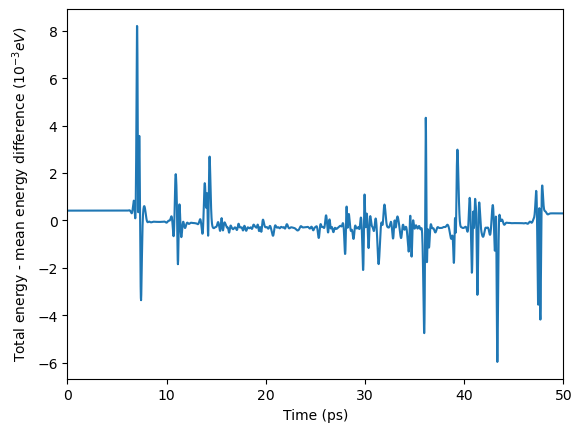

In [17]:
atoms = rd1['atoms']
field = rd1['field']

field_energy = np.sum(np.array(field.history['energy']),axis = 1)
time_axis = field.history['t']

from calculator.function import LJ_potential

coltime = np.array(get_colliding_time(atoms, 0))

N_pairs = int(len(atoms.r)/2)

r_ar = np.array(atoms.trajectory['r'])[:,0]
r_xe = np.array(atoms.trajectory['r'])[:,1]

v_ar = np.array(atoms.trajectory['r_dot'])[:,0]
v_xe = np.array(atoms.trajectory['r_dot'])[:,1]

t = red.convert_time(np.array(atoms.trajectory['t']))

k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
    + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)
k = red.convert_energy(k,'ev') * 1e3

d_arxe = r_ar - r_xe
d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)
v = red.convert_energy(v,'ev') * 1e3

hem = red.convert_energy(
    np.sum(field.history['energy'],axis = 1), 'ev') * 1e3
tem = red.convert_time(field.history['t'])

fig,ax = plt.subplots()

mean_total = np.mean(red.convert_energy(k+ v + hem, 'ev'))*1e3

ax.plot(t, red.convert_energy(k+ v + hem, 'ev')*1e3 - mean_total)

ax.set_xlim(0,50)

ax.set_xlabel('Time (ps)')
ax.set_ylabel(r'Total energy - mean energy difference $(10^{-3} eV)$')

total = k+ v + hem
print(red.convert_energy(total[0] - total[-1],'ev') * 1e3)
print(red.convert_energy((total[0] - total[-1]) / (100 * 2 + 2 * 3),'ev') * 1e3)


In [5]:
np.random.seed(10) # h = 0.0, T = 135
# h = 0.2, T = 100

Lxy = 3e7; Lz = 3e3
T = 100

atoms = AtomsInBox(
    Lxy = Lxy, Lz = Lz, cell_width = (1e6,1e2), 
    mass_dict = red.mass_dict)

v_ar = np.sqrt((T * red.boltzmann / red.epsilon) )
v_xe = - v_ar / np.sqrt(red.mass_dict['Xe'])

atoms.add(
        elements = ["Ar"],
        r = np.array([[0.0, 0, -6/2]]),
        r_dot = np.array([[0.0, 0.0, v_ar]])# / np.sqrt(2)
        )

atoms.add(
        elements = ["Xe"],
        r = np.array([[0.2,0.0,6/2]]),
        r_dot = np.array([[0.00, 0.00, v_xe]])# / np.sqrt(2)
        )

idxAr = atoms.element_idx(element = "Ar")
idxXe = atoms.element_idx(element = "Xe")
epsilon_mat, sigma_mat = red.generate_LJparam_matrix(idxAr = idxAr, idxXe = idxXe)

# calculator to the atoms object
atoms.add_calculator(
    calculator_class = Calculator,
    calculator_kwargs = {
        "epsilon": epsilon_mat, "sigma" : sigma_mat, 
        "positive_atom_idx" : idxXe, "negative_atom_idx" : idxAr,
        "mu0" : red.mu0, "d" : red.d0, "a" : red.a, 'd7':red.d7
    })

atoms.update_distance()

In [6]:
k_vector_int = np.array(
    [[i,0,0] for i in range(1,100)]
    ,dtype=np.float64)

Afield = CavityVectorPotential(
    k_vector_int = k_vector_int, 
    amplitude = 'boltzmann', #  'zero', #
    Lxy = Lxy, Lz = Lz, constant_c = red.c, coupling_strength = 20 * Lxy , 
    T = T / red.temp
    )
t, rd = single_collision_simulation(
    0, h = 1e-3, atoms = atoms, field = Afield, potential_threshold = 1e-5,
    max_steps = 40000, verbose = True, record_every = 1)

Cycle: 0, iterations: 1, potential: -2.0427E-04
Cycle: 0, iterations: 2, potential: -2.0456E-04
Cycle: 0, iterations: 3, potential: -2.0485E-04
Cycle: 0, iterations: 4, potential: -2.0514E-04
Cycle: 0, iterations: 5, potential: -2.0543E-04
Cycle: 0, iterations: 6, potential: -2.0572E-04
Cycle: 0, iterations: 7, potential: -2.0601E-04
Cycle: 0, iterations: 8, potential: -2.0630E-04
Cycle: 0, iterations: 9, potential: -2.0660E-04
Cycle: 0, iterations: 10, potential: -2.0689E-04
Cycle: 0, iterations: 11, potential: -2.0718E-04
Cycle: 0, iterations: 12, potential: -2.0748E-04
Cycle: 0, iterations: 13, potential: -2.0777E-04
Cycle: 0, iterations: 14, potential: -2.0807E-04
Cycle: 0, iterations: 15, potential: -2.0836E-04
Cycle: 0, iterations: 16, potential: -2.0866E-04
Cycle: 0, iterations: 17, potential: -2.0896E-04
Cycle: 0, iterations: 18, potential: -2.0925E-04
Cycle: 0, iterations: 19, potential: -2.0955E-04
Cycle: 0, iterations: 20, potential: -2.0985E-04
Cycle: 0, iterations: 21, pot

(0.0045723034861922295+0j)
(2.219564799122441e-05+0j)


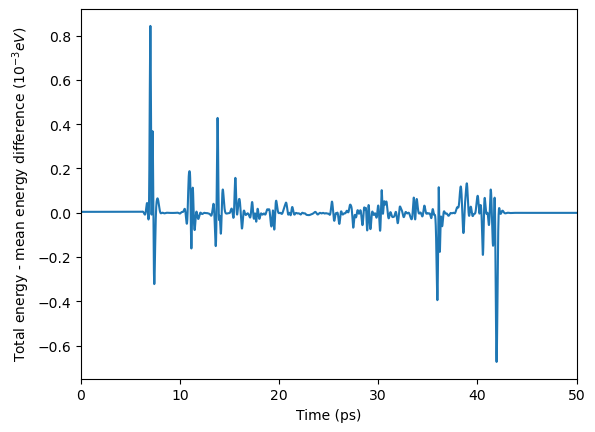

In [16]:
field_energy = np.sum(np.array(field.history['energy']),axis = 1)
time_axis = field.history['t']

from calculator.function import LJ_potential

atoms = rd['atoms']
field = rd['field']

coltime = np.array(get_colliding_time(atoms, 0))

N_pairs = int(len(atoms.r)/2)

r_ar = np.array(atoms.trajectory['r'])[:,0]
r_xe = np.array(atoms.trajectory['r'])[:,1]

v_ar = np.array(atoms.trajectory['r_dot'])[:,0]
v_xe = np.array(atoms.trajectory['r_dot'])[:,1]

t = red.convert_time(np.array(atoms.trajectory['t']))

k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
    + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)
k = red.convert_energy(k,'ev') * 1e3

d_arxe = r_ar - r_xe
d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)
v = red.convert_energy(v,'ev') * 1e3

hem = red.convert_energy(
    np.sum(field.history['energy'],axis = 1), 'ev') * 1e3
tem = red.convert_time(field.history['t'])

fig,ax = plt.subplots()

mean_total = np.mean(red.convert_energy(k+ v + hem, 'ev'))*1e3

ax.plot(t, red.convert_energy(k+ v + hem, 'ev')*1e3 - mean_total)

ax.set_xlim(0,50)
ax.set_xlabel('Time (ps)')
ax.set_ylabel(r'Total energy - mean energy difference $(10^{-3} eV)$')

total = k+ v + hem
print(red.convert_energy(total[0] - total[-1],'ev') * 1e3)
print(red.convert_energy((total[0] - total[-1]) / (100 * 2 + 2 * 3),'ev') * 1e3)
